## Init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install -q efficientnet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle
import scipy.io
import tarfile
# import csv
# # import sys
import os
import tensorflow as tf
# import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    LearningRateScheduler,
    ModelCheckpoint,
    EarlyStopping
)
# from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split
import PIL
# from PIL import ImageOps, ImageFilter

In [5]:
os.chdir("/content/drive/MyDrive/3_XuLyAnh_Flowers")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1tU35xhAZwBdemxnc1j9Q3JzeU3wbyFMK/3_XuLyAnh_Flowers'

In [6]:
EPOCHS        = 5
BATCH_SIZE    = 8
LR_step1      = 1e-3
LR_step2      = 1e-4
LR_step3      = 1e-5
VAL_SPLIT     = 0.2
CLASS_NUM     = 15       #102
IMG_SIZE      = 250    # (725*500)
IMG_CHANNELS  = 3
input_shape   = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED   = 42

## Data

### Load Data

In [7]:
# # Đường dẫn đến tệp .tgz cần giải nén
# file_path = os.path.join(os.getcwd(), '102flowers.tgz')

# # Mở tệp .tgz
# with tarfile.open(file_path, 'r:gz') as tar:
#     # Giải nén toàn bộ nội dung của tệp .tgz vào thư mục hiện tại
#     tar.extractall()

In [8]:
DATA_PATH = os.getcwd()
PATH = os.getcwd() + "/jpg/"

In [9]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH + '/102flowers.tgz'))

# load file label:  label (1 -> 102) == -1 ==>  (0 -> 101)
df['Category'] = scipy.io.loadmat(DATA_PATH + '/imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [10]:
top_15_categories = ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [12]:
# Lọc DataFrame ban đầu
df_15 = df[df['Category'].isin(top_15_categories)]
print(df_15)

                       Id Category
0     jpg/image_00001.jpg       76
1     jpg/image_00002.jpg       76
2     jpg/image_00003.jpg       76
3     jpg/image_00004.jpg       76
4     jpg/image_00005.jpg       76
...                   ...      ...
7745  jpg/image_07746.jpg       96
7746  jpg/image_07747.jpg       96
7747  jpg/image_07748.jpg       96
7748  jpg/image_07749.jpg       96
7749  jpg/image_07750.jpg       96

[1796 rows x 2 columns]


In [ ]:
# df.head(5)

### Visualization Data

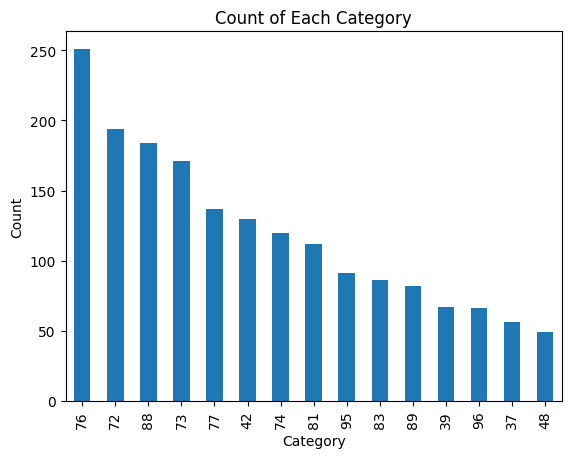

In [13]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
df_15['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.show()

In [ ]:
# # Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
# df['Category'].value_counts().plot(kind='bar')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.title('Count of Each Category')
# plt.show()

In [14]:
print(f"Có {df_15['Category'].nunique()} loài hoa")
print("Giá trị lớn nhất của cột 'Category':", df['Category'].value_counts().max())
print("Giá trị nhỏ nhất của cột 'Category':", df['Category'].value_counts().min())

Có 15 loài hoa
Giá trị lớn nhất của cột 'Category': 258
Giá trị nhỏ nhất của cột 'Category': 40


In [ ]:
# print(f"Có {df['Category'].nunique()} loài hoa")
# print("Giá trị lớn nhất của cột 'Category':", df['Category'].value_counts().max())
# print("Giá trị nhỏ nhất của cột 'Category':", df['Category'].value_counts().min())

In [15]:
df_15['Category'].unique()   # giá trị từ 1 đến 101

array(['76', '72', '88', '73', '81', '77', '74', '42', '83', '89', '39',
       '37', '48', '95', '96'], dtype=object)

In [ ]:
# df['Category'].unique()   # giá trị từ 1 đến 101

In [16]:
PATH = os.getcwd() + "/"

Random Sample


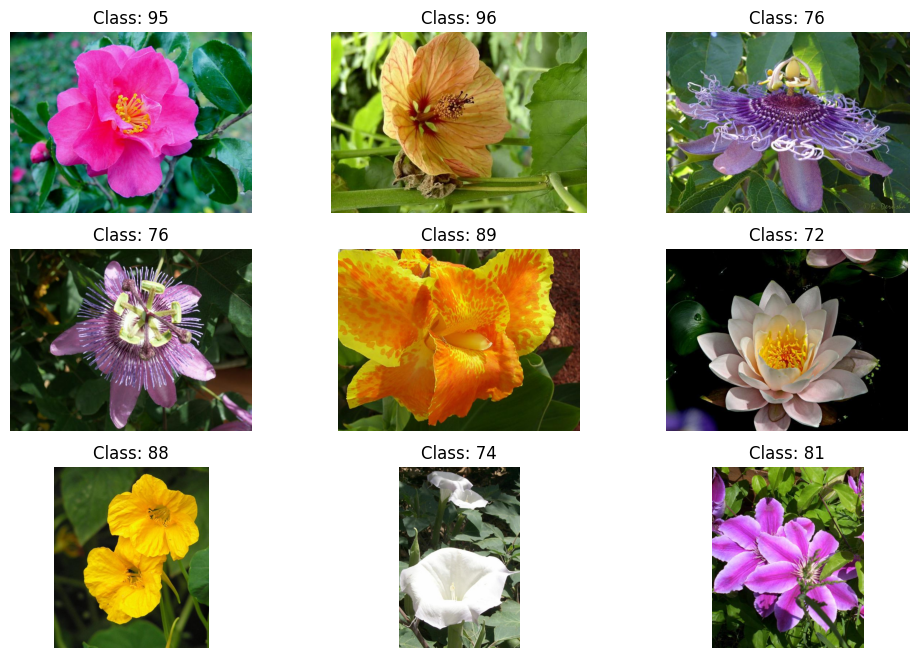

In [17]:
print('Random Sample')
plt.figure(figsize = (12, 8))
random_image = df_15.sample(n = 9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH + path)
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('Class: ' + str(random_image_cat[index]))
    plt.axis('off')

plt.show()

In [ ]:
# print('Random Sample')
# plt.figure(figsize = (12, 8))
# random_image = df.sample(n = 9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH + path)
#     plt.subplot(3, 3, index + 1)
#     plt.imshow(im)
#     plt.title('Class: ' + str(random_image_cat[index]))
#     plt.axis('off')

# plt.show()

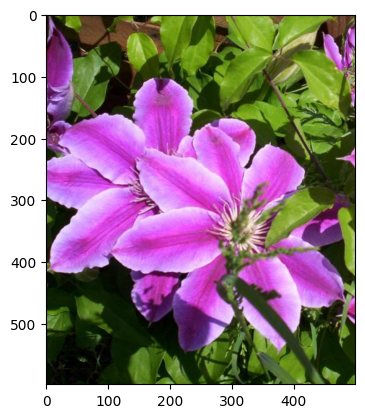

(500, 598)

In [18]:
image = PIL.Image.open(PATH + path)
imgplot = plt.imshow(image)
plt.show()
image.size

### Split Train Test

In [19]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(
        df_15['Id'],
        df_15['Category'],
        test_size = 0.2,
        random_state = 42,
        stratify = df_15['Category']
)
train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels
train_files.shape, test_files.shape

((1436, 2), (360, 2))

In [ ]:
# train_files, test_files, train_labels, test_labels = \
#     train_test_split(
#         df['Id'],
#         df['Category'],
#         test_size = 0.2,
#         random_state = 42,
#         stratify = df['Category']
# )
# train_files = pd.DataFrame(train_files)
# test_files = pd.DataFrame(test_files)
# train_files['Category'] = train_labels
# test_files['Category'] = test_labels
# train_files.shape, test_files.shape

In [20]:
train_files.head(5)

,Id,Category
270,jpg/image_00271.jpg,72
6223,jpg/image_06224.jpg,48
263,jpg/image_00264.jpg,72
6210,jpg/image_06211.jpg,48
7678,jpg/image_07679.jpg,95


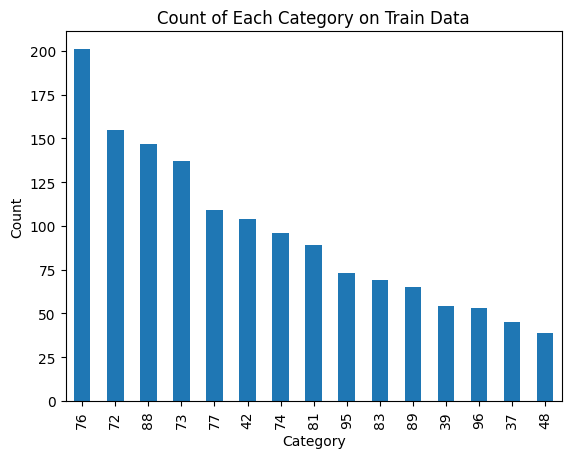

In [21]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
train_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Train Data')
plt.show()

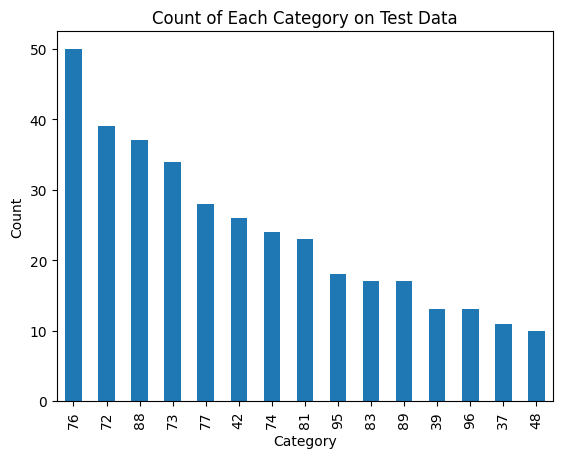

In [22]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
test_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Test Data')
plt.show()

### Data augmentation

In [ ]:
# Tạo một đối tượng ImageDataGenerator cho dữ liệu huấn luyện (train_datagen) và một đối tượng ImageDataGenerator cho dữ liệu kiểm tra (test_datagen)
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,  # Rescale giá trị pixel của ảnh về khoảng [0, 1]
    rotation_range = 50,  # Phạm vi góc quay ngẫu nhiên cho các hình ảnh (tính bằng độ)
    shear_range = 0.2,  # Phạm vi biến dạng cắt ảnh
    zoom_range = [0.75, 1.25],  # Phạm vi phóng to hoặc thu nhỏ ảnh
    brightness_range = [0.5, 1.5],  # Phạm vi điều chỉnh độ sáng của ảnh
    width_shift_range = 0.1,  # Phạm vi dịch ngang ảnh
    height_shift_range = 0.1,  # Phạm vi dịch dọc ảnh
    horizontal_flip = True  # Ngẫu nhiên lật ảnh theo chiều ngang
)

# Đối tượng test_datagen chỉ thực hiện rescale giá trị pixel về khoảng [0, 1], không thực hiện các phép biến đổi dữ liệu khác
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [ ]:
# Tạo generator cho dữ liệu huấn luyện và kiểm tra

# Generator cho dữ liệu huấn luyện (train_generator)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_files,  # DataFrame chứa thông tin về các hình ảnh huấn luyện
    directory = DATA_PATH,  # Đường dẫn đến thư mục chứa các hình ảnh
    x_col = 'Id',  # Tên cột trong DataFrame chứa tên các file ảnh
    y_col = 'Category',  # Tên cột trong DataFrame chứa nhãn của các ảnh
    target_size = (IMG_SIZE, IMG_SIZE),  # Kích thước mà các ảnh sẽ được resize về
    batch_size = BATCH_SIZE,  # Kích thước batch
    class_mode = 'categorical',  # Loại hình phân loại của dữ liệu (categorical cho one-hot encoding)
    shuffle = True,  # Xáo trộn dữ liệu sau mỗi epoch
    seed = RANDOM_SEED  # Seed để xáo trộn dữ liệu
)

# Generator cho dữ liệu kiểm tra (test_generator)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_files,  # DataFrame chứa thông tin về các hình ảnh kiểm tra
    directory = DATA_PATH,  # Đường dẫn đến thư mục chứa các hình ảnh
    x_col = 'Id',  # Tên cột trong DataFrame chứa tên các file ảnh
    y_col = 'Category',  # Tên cột trong DataFrame chứa nhãn của các ảnh
    target_size = (IMG_SIZE, IMG_SIZE),  # Kích thước mà các ảnh sẽ được resize về
    batch_size = BATCH_SIZE,  # Kích thước batch
    class_mode = 'categorical',  # Loại hình phân loại của dữ liệu (categorical cho one-hot encoding)
    shuffle = False,  # Không cần xáo trộn dữ liệu cho dữ liệu kiểm tra
    seed = RANDOM_SEED  # Seed để xáo trộn dữ liệu
)

Found 1436 validated image filenames belonging to 15 classes.
Found 360 validated image filenames belonging to 15 classes.


Ví dụ về hình ảnh từ train_generator


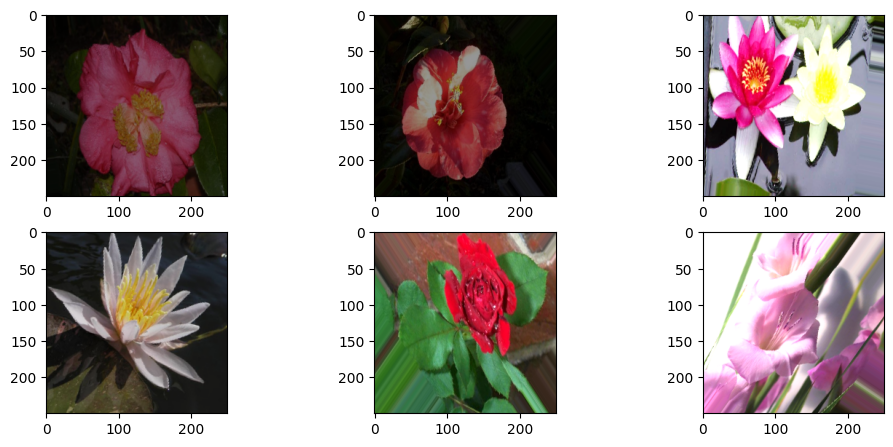

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x, y = train_generator.next()
print('Ví dụ về hình ảnh từ train_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

Ví dụ về hình ảnh từ test_generator


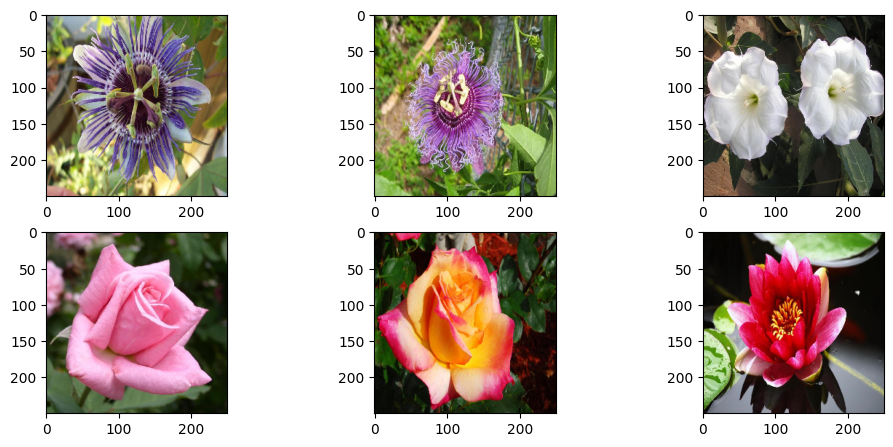

In [ ]:
x, y = test_generator.next()
print('Ví dụ về hình ảnh từ test_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

## Model Lenet5

### Lenet5

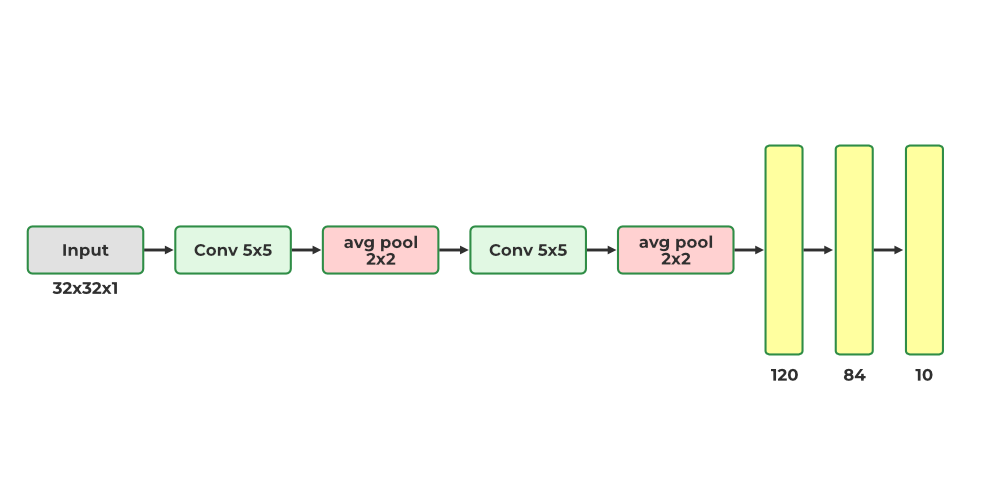

In [ ]:
lenet5_model = M.Sequential()
lenet5_model.add(L.Conv2D(6, 5, activation='tanh', input_shape=input_shape))
lenet5_model.add(L.AveragePooling2D(2))
lenet5_model.add(L.Activation('sigmoid'))
lenet5_model.add(L.Conv2D(16, 5, activation='tanh'))
lenet5_model.add(L.AveragePooling2D(2))
lenet5_model.add(L.Activation('sigmoid'))
lenet5_model.add(L.Conv2D(6, 5, activation='tanh'))
lenet5_model.add(L.Flatten())
lenet5_model.add(L.Dense(2048, activation='tanh'))
# lenet5_model.add(L.Dense(10, activation='softmax'))

In [ ]:
# Print model summary
lenet5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 123, 123, 6)       0         
 Pooling2D)                                                      
                                                                 
 activation (Activation)     (None, 123, 123, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 59, 59, 16)        0         
 gePooling2D)                                                    
                                                                 
 activation_1 (Activation)   (None, 59, 59, 16)        0

In [ ]:
model = M.Sequential()
model.add(lenet5_model)
# model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              37178526  
                                                                 
 dense_1 (Dense)             (None, 15)                30735     
                                                                 
Total params: 37209261 (141.94 MB)
Trainable params: 37209261 (141.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(len(model.layers))
print(len(model.trainable_variables))

2
10


In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.sequential.Sequential object at 0x7b75f92a91b0> True
<keras.src.layers.core.dense.Dense object at 0x7b75f930f820> True


In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

earlystop:
- monitor - giám sát trên thang đo val_acc
- patience - số lượng epochs không cải thiện độ chính xác sẽ dừng
- restore_best_weights - quay lại trọng số cho độ chính xác tốt nhất

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model_test.hdf5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# scores = model.evaluate(test_generator, verbose=1)
# print('Accuracy: %.2f%%' % (scores[1] * 100))

### Huấn luyện

đã huấn luyện được 12 epoch

In [ ]:
# fit include generator
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 4.3194 - accuracy: 0.0973
Epoch 1: saving model to best_model_test.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


179/179 [==============================] - 987s 5s/step - loss: 4.3194 - accuracy: 0.0973 - val_loss: 3.1638 - val_accuracy: 0.1028
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 3.2289 - accuracy: 0.0924
Epoch 2: saving model to best_model_test.hdf5
179/179 [==============================] - 41s 228ms/step - loss: 3.2289 - accuracy: 0.0924 - val_loss: 3.1067 - val_accuracy: 0.1389
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 3.1929 - accuracy: 0.0917
Epoch 3: saving model to best_model_test.hdf5
179/179 [==============================] - 40s 226ms/step - loss: 3.1929 - accuracy: 0.0917 - val_loss: 3.4402 - val_accuracy: 0.0722
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 3.2343 - accuracy: 0.0903
Epoch 4: saving model to best_model_test.hdf5
179/179 [==============================] - 43s 238ms/step - loss: 3.2343 - accuracy: 0.0903 - val_loss: 3.2831 - val_accuracy: 0.0722
Epoch 5/50
179/179 [====================

In [ ]:
model.save('./SaveModel/model_lenet5_step1.hdf5')
# model.load_weights('best_model_test.hdf5')

## Cur

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 2s 46ms/step - loss: 3.1067 - accuracy: 0.1389
Accuracy: 13.89%


In [ ]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label = 'Training acc')
    plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
#     plt.figure()
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

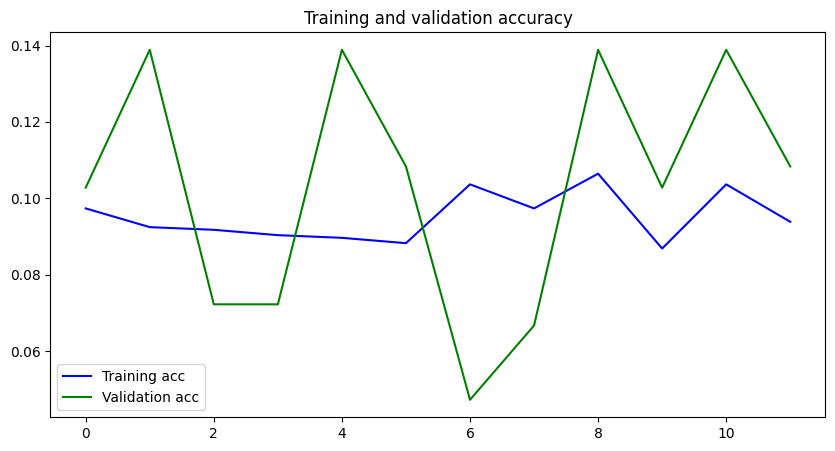

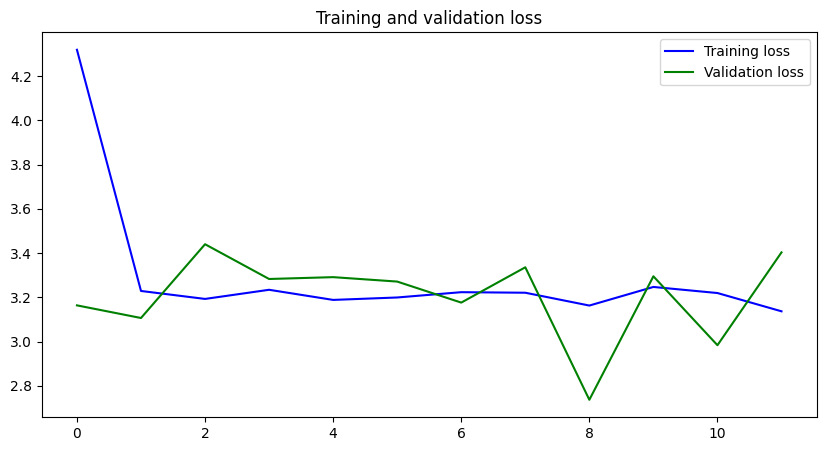

In [ ]:
plot_history(history)

## Model AlexNet

### AlexNet

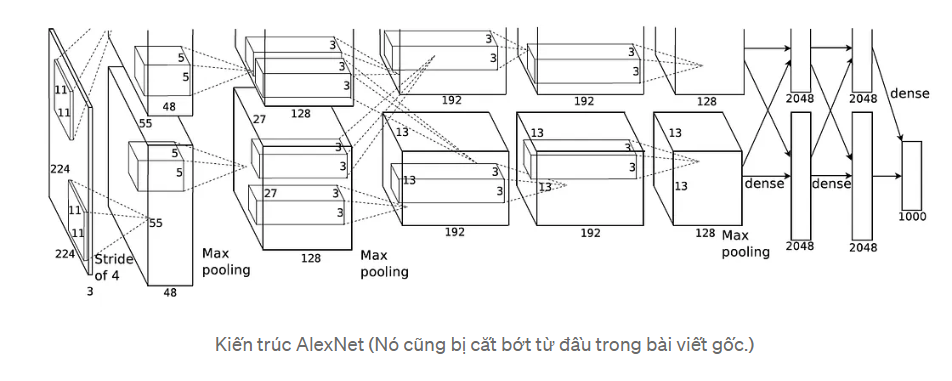

In [ ]:
model_alexnet = M.Sequential()
model_alexnet.add(L.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape))
model_alexnet.add(L.Conv2D(96, 11, strides=4, padding='same'))
model_alexnet.add(L.Lambda(tf.nn.local_response_normalization))
model_alexnet.add(L.Activation('relu'))
model_alexnet.add(L.MaxPooling2D(3, strides=2))
model_alexnet.add(L.Conv2D(256, 5, strides=4, padding='same'))
model_alexnet.add(L.Lambda(tf.nn.local_response_normalization))
model_alexnet.add(L.Activation('relu'))
model_alexnet.add(L.MaxPooling2D(3, strides=2))
model_alexnet.add(L.Conv2D(384, 3, strides=4, padding='same'))
model_alexnet.add(L.Activation('relu'))
model_alexnet.add(L.Conv2D(384, 3, strides=4, padding='same'))
model_alexnet.add(L.Activation('relu'))
model_alexnet.add(L.Conv2D(256, 3, strides=4, padding='same'))
model_alexnet.add(L.Activation('relu'))
model_alexnet.add(L.Flatten())
model_alexnet.add(L.Dense(4096, activation='relu'))
model_alexnet.add(L.Dropout(0.5))
model_alexnet.add(L.Dense(4096, activation='relu'))
model_alexnet.add(L.Dropout(0.5))
model_alexnet.add(L.Dense(10, activation='softmax'))
model_alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation_2 (Activation)   (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 256)         614656    
                                                      

In [ ]:
model = M.Sequential()
model.add(model_alexnet)
# model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10)                21622154  
                                                                 
 dense_5 (Dense)             (None, 15)                165       
                                                                 
Total params: 21622319 (82.48 MB)
Trainable params: 21622319 (82.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(len(model.layers))
print(len(model.trainable_variables))

2
18


In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.sequential.Sequential object at 0x7b75f0207d30> True
<keras.src.layers.core.dense.Dense object at 0x7b75f025fd60> True


In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

### Huấn luyện

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model_test_2.hdf5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# fit include generator
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 2.6716 - accuracy: 0.1141
Epoch 1: saving model to best_model_test_2.hdf5
179/179 [==============================] - 55s 268ms/step - loss: 2.6716 - accuracy: 0.1141 - val_loss: 2.6515 - val_accuracy: 0.1083
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 2.6421 - accuracy: 0.1317
Epoch 2: saving model to best_model_test_2.hdf5
179/179 [==============================] - 39s 220ms/step - loss: 2.6421 - accuracy: 0.1317 - val_loss: 2.6289 - val_accuracy: 0.1389
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 2.6261 - accuracy: 0.1380
Epoch 3: saving model to best_model_test_2.hdf5
179/179 [==============================] - 39s 220ms/step - loss: 2.6261 - accuracy: 0.1380 - val_loss: 2.6176 - val_accuracy: 0.1389
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 2.6151 - accuracy: 0.1408
Epoch 4: saving model to best_model_test_2.hdf5
179/179 [=============

## this

In [ ]:
model.save('./SaveModel/model_alexnet_step1.hdf5')
# model.load_weights('best_model_test_2.hdf5')

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 3s 58ms/step - loss: 2.6289 - accuracy: 0.1389
Accuracy: 13.89%


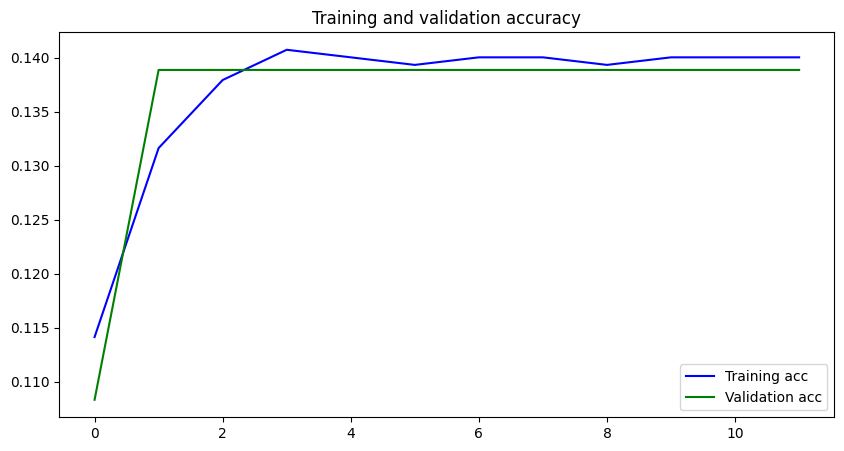

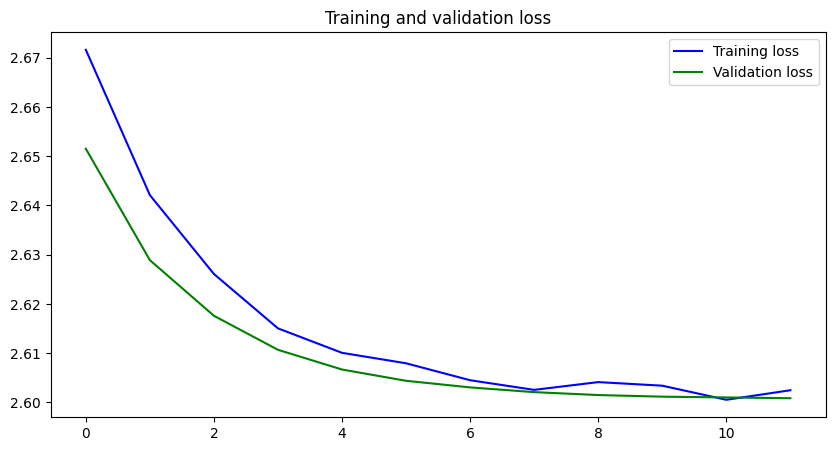

In [ ]:
plot_history(history)

## Model Transfer Learning EfficientNetB6

In [ ]:
input_shape

(250, 250, 3)

In [ ]:
base_model = efn.EfficientNetB6(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

165527152/165527152 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 125, 125, 56)         1512      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 125, 125, 56)         224       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 125, 125, 56)         0         ['stem_bn[0][0]'

In [ ]:
base_model.trainable = False

In [ ]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b6 (Functiona  (None, 8, 8, 2304)        40960136  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2304)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 15)                34575     
                                                                 
Total params: 40994711 (156.38 MB)
Trainable params: 34575 (135.06 KB)
Non-trainable params: 40960136 (156.25 MB)
_________________________________________________________________


In [ ]:
print(len(model.layers))

3


In [ ]:
len(model.trainable_variables)

2

In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x7b75fb28b940> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b75f845cb50> True
<keras.src.layers.core.dense.Dense object at 0x7b75fb28ec50> True


### Step 1: Freeze Base Layer + Training new Head Classifier

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.hdf5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

Đánh giá trước khi huấn luyện

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 15s 90ms/step - loss: 2.7351 - accuracy: 0.0444
Accuracy: 4.44%


In [ ]:
print(train_generator.samples)

1436


In [ ]:
# fit include generator
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 5,
    callbacks = callbacks_list
)

Epoch 1/5
179/179 [==============================] - ETA: 0s - loss: 1.7102 - accuracy: 0.5154
Epoch 1: saving model to best_model.hdf5
179/179 [==============================] - 69s 295ms/step - loss: 1.7102 - accuracy: 0.5154 - val_loss: 0.9887 - val_accuracy: 0.7250
Epoch 2/5
179/179 [==============================] - ETA: 0s - loss: 1.0187 - accuracy: 0.7143
Epoch 2: saving model to best_model.hdf5
179/179 [==============================] - 44s 246ms/step - loss: 1.0187 - accuracy: 0.7143 - val_loss: 0.6962 - val_accuracy: 0.8167
Epoch 3/5
179/179 [==============================] - ETA: 0s - loss: 0.8090 - accuracy: 0.7794
Epoch 3: saving model to best_model.hdf5
179/179 [==============================] - 44s 246ms/step - loss: 0.8090 - accuracy: 0.7794 - val_loss: 0.5525 - val_accuracy: 0.8667
Epoch 4/5
179/179 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.8123
Epoch 4: saving model to best_model.hdf5
179/179 [==============================] - 44s 242ms/s

In [ ]:
model.save('./SaveModel/model_step1.hdf5')
model.load_weights('best_model.hdf5')

Đánh giá sau khi huấn luyện

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 4s 95ms/step - loss: 0.4287 - accuracy: 0.8889
Accuracy: 88.89%


Visualizer training history

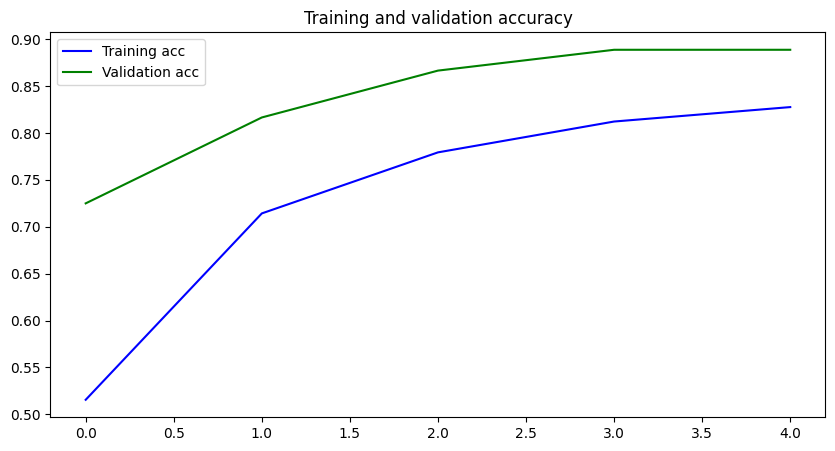

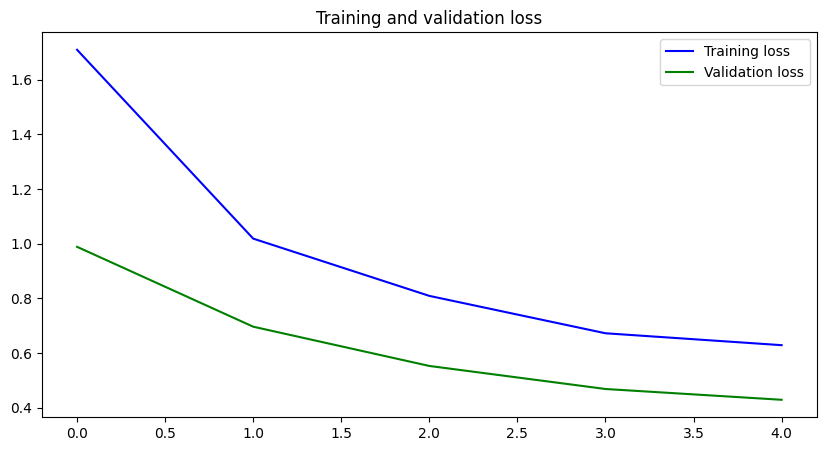

In [ ]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label = 'Training acc')
    plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
#     plt.figure()
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


plot_history(history)

### Step 2: Freeze a half layers of base_model and fine-turning

In [ ]:
# let's take a look to see how many layers are in the base model
print('Number of layers in the base model:', len(base_model.layers))

Number of layers in the base model: 659


In [ ]:
base_model.trainable = True

# fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) // 2

# freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
len(base_model.trainable_variables)

291

In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x7b75fb28b940> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b75f845cb50> True
<keras.src.layers.core.dense.Dense object at 0x7b75fb28ec50> True


In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step2),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b6 (Functiona  (None, 8, 8, 2304)        40960136  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2304)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 15)                34575     
                                                                 
Total params: 40994711 (156.38 MB)
Trainable params: 37731045 (143.93 MB)
Non-trainable params: 3263666 (12.45 MB)
_________________________________________________________________


In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 10s 94ms/step - loss: 0.4287 - accuracy: 0.8889
Accuracy: 88.89%


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
)

In [ ]:
model.save('./SaveModel/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate(test_generator, verbose = 1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

In [ ]:
plot_history(history)

### Step 3: No Freeze Base model and full fine-turning

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(lr = LR_step3),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
)

In [ ]:
model.save('./SaveModel/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose = 1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

## Final Score

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
predictions = model.predict(test_generator, verbose = 1)
predictions = np.argmax(predictions, axis = -1)         # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k, v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir = test_generator.filenames
submission = pd.DataFrame(
    {'Predict': predictions},
    columns = ['Predict'],
    index = filenames_with_dir
)
test_files.index = test_files['Id']
tmp_y = pd.concat(
    [submission['Predict'], test_files['Category']],
    axis = 1,
    sort = False
)
tmp_y.head(5)

In [ ]:
print('Accuracy: %.2f%%' % (
    accuracy_score(tmp_y['Category'], tmp_y['Predict']) * 100
))

### confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# tmp_y['Category'] là nhãn thực tế, tmp_y['Predict'] là dự đoán của mô hình
conf_matrix = confusion_matrix(tmp_y['Category'], tmp_y['Predict'])

print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Vẽ heatmap cho confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# In ra các trường hợp nhầm lẫn
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j and conf_matrix[i][j] > 0:
            print("Thực tế:", i, "Dự đoán:", j, "Số lượng:", conf_matrix[i][j])

In [ ]:
# Tính tổng số lượng nhầm lẫn cho từng loại
errors_per_category = conf_matrix.sum(axis=1)

# Xây dựng bảng thống kê
error_table = []
for i, error_count in enumerate(errors_per_category):
    error_table.append({'Loại': i, 'Số lượng nhầm lẫn': error_count})

# Sắp xếp bảng thống kê theo số lượng nhầm lẫn giảm dần
error_table.sort(key=lambda x: x['Số lượng nhầm lẫn'], reverse=True)

# In bảng thống kê
print("Bảng thống kê số loại bị nhầm lẫn nhiều nhất từ cao đến thấp:")
for item in error_table:
    print("Loại:", item['Loại'], "- Số lượng nhầm lẫn:", item['Số lượng nhầm lẫn'])

In [ ]:
# Lấy thông tin để vẽ biểu đồ
categories = [str(item['Loại']) for item in error_table[0:15]]
errors = [item['Số lượng nhầm lẫn'] for item in error_table[0:15]]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(categories, errors, color='skyblue')
plt.xlabel('Loại')
plt.ylabel('Số lượng nhầm lẫn')
plt.title('Số lượng loại bị nhầm lẫn nhiều nhất từ cao đến thấp cho từng loại')
plt.xticks(categories)
plt.show()


Category: ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [ ]:
print(categories)

Đây là các 15 loại nhầm lẫn nhiều nhất.
Công việc tiếp theo:
- Tính ra % chính xác của model efficientnetB6 với 15 loại này (dự đoán sẽ giảm so với 84% trên toàn bộ tập dữ liệu)
- Cắt bộ dữ liệu ra 15 loại
- Huấn luyện trên model Lenet5 với 37tr tham số, Alexnet, GoogleNet và thống kê kết quả

tính độ chính xác của 15 loại trên best model efficientNetB6:
- phải huấn luyện lại mô hình trên 15 loại này
- rồi đánh giá lại, mà huấn luyện rất mất thời gian, chắc là dùng lại model hiện giờ luôn.